# Examine the effect of dithering patterns on differential galaxy counts#

This jupyter notebook demonstrates using the 'galaxy counts' metric to calculate the number of galaxies expected at a particular point of the sky ($N$), and then postprocess these results to calculate $dN/<N>$, the variation in galaxy counts at each point. In the current implementation of the metric, these variations would be due to variation in coadded depth. 

The dithering patterns used are part of sims_maf, and are generally based on dither patterns presented by Awan, Gawiser, Kurczynski, and Carroll in https://guidebook.com/guide/28858/event/10156541/. 

--------

Import the python and MAF items we need. 

In [1]:
from __future__ import print_function

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.utils as mafUtils
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

# Import the contributed metrics, to get GalaxyCountsMetric
from mafContrib import GalaxyCountsMetric

Generate the metric data, for various dither patterns. See the Dithering notebook in the tutorials directory for more information on the various dither patterns available through MAF. 

First connect to an opsim output file. In this case, we're interested in running on an old output file that only contains the 'summary' table, so I'll demonstrate that here.

In [2]:
runName = 'astro-lsst-01_2022'
dbfile = '../../tutorials/astro-lsst-01_2022.db'
opsdb = db.OpsimDatabase(dbfile)

For the purposes of this notebook, we'll only look at opsim data from the r band, and that was obtained for the WFD.

In [3]:
propIds, propTags = opsdb.fetchPropInfo()
wfdWhere = opsdb.createSQLWhere('WFD', propTags)
sqlconstraint  = wfdWhere + ' and filter="r"'
print(sqlconstraint)

proposalId = 3 and filter="r"


For an older run with only a summary table, we have to just know the propID corresponding to WFD.

---
Next, set up the slicers, metric, and MetricBundles, along with various stackers for the dithering patterns. 

In [4]:
# Set up a dictionary to hold the metric bundles, for each different dithering pattern.
myBundles = {}

In [5]:
# Set up the undithered version.
nside = 64
raCol = 'fieldRA'
decCol = 'fieldDec'
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol, latLonDeg=True)
metric = GalaxyCountsMetric(nside=nside)
myBundles['undithered'] = metricBundles.MetricBundle(metric=metric, slicer=slicer, constraint=sqlconstraint,
                                                     runName=runName, metadata='No dithering')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
# Set up a spiral dithered version. 
raCol = 'spiralDitherFieldPerNightRa'
decCol = 'spiralDitherFieldPerNightDec'
spiralstacker = stackers.SpiralDitherFieldPerNightStacker(fieldIdCol='fieldId')
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol, latLonDeg=True)
myBundles['spiral'] = metricBundles.MetricBundle(metric=metric, slicer=slicer, constraint=sqlconstraint,
                                                stackerList=[spiralstacker], runName=runName, metadata='Spiral dither')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
# Set up a random dither, with a specific random seed.
raCol = 'randomDitherFieldPerNightRa'
decCol = 'randomDitherFieldPerNightDec'
randomstacker = stackers.RandomDitherFieldPerNightStacker(randomSeed=43)
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol, latLonDeg=True)
myBundles['random'] = metricBundles.MetricBundle(metric=metric, slicer=slicer, constraint=sqlconstraint,
                                                stackerList=[randomstacker], runName=runName, metadata='Random dither')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Calculate the metric values - remember, these are the galaxy counts in each healpix, but not scaled to $dN/<N>$.

Set up to save the output in outDir, and also to keep track of the metrics which have been run, using the resultsDb.

In [8]:
outDir = 'galaxyCounts'
resultsDb = db.ResultsDb(outDir=outDir)
mb = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)

Run the metrics.

In [9]:
mb.runAll()

Querying database SummaryAllProps with constraint proposalId = 3 and filter="r" for columns ['fieldId', 'fieldRA', 'night', 'fiveSigmaDepth', 'fieldDec']
Found 445601 visits
Running:  ['undithered']
Completed metric generation.
Running:  ['spiral']
Completed metric generation.
Running:  ['random']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


We could plot these results, or calculate summary statistics. But really what we want to do is do some post-processing to
* calculate the mean of the resulting data
* calculate the difference in galaxy counts in a healpix versus the mean, and divide by the mean (calculate $dN/<N>$)
* throw out the parts of the sky where dithering moved pointings onto a part of the sky with very few visits (remove the "ringing" around the edges)
* and it's nice to update the plot labels from 'galaxy counts' etc. to dN/N

In [10]:
# Create a 'plotHandler' object so that we can make multiple plots and easily save them/record them to the resultsDb
plotHandler = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)

undithered 139.160730597
monopole: -0.0508315  dipole: lon: 169.439, lat: -70.318, amp: 0.131992
spiral 135.649135676
monopole: -0.0615361  dipole: lon: 141.29, lat: -73.7233, amp: 0.155936
random 135.123257202
monopole: -0.0625808  dipole: lon: 137.115, lat: -73.8364, amp: 0.15877


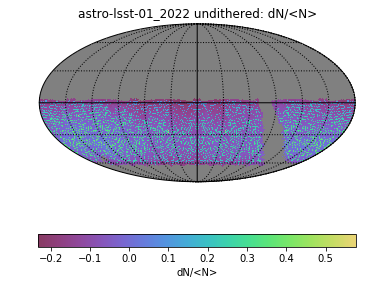

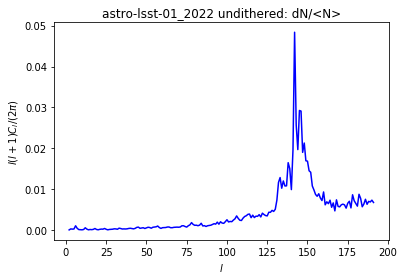

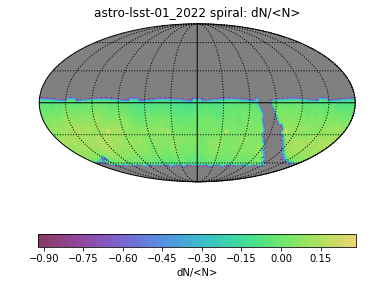

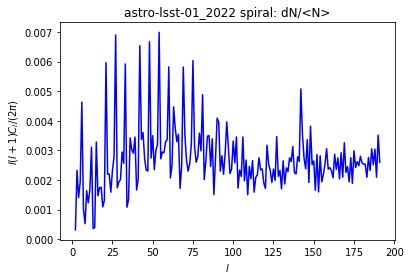

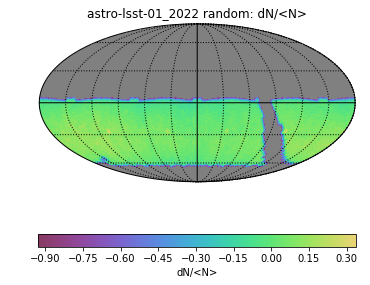

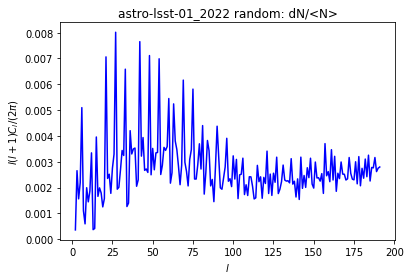

In [11]:
# Adjust metric data from galaxy counts to dN/<N>
for dither in myBundles:
    mean = myBundles[dither].metricValues.compressed().mean()
    print(dither, mean)
    myBundles[dither].metricValues = (myBundles[dither].metricValues - mean) / mean
    plotDict = {'xlabel':'dN/<N>', 'title':'%s %s: dN/<N>' %(runName, dither)}
    myBundles[dither].setPlotDict(plotDict)
    myBundles[dither].setPlotFuncs([plots.HealpixSkyMap(), plots.HealpixPowerSpectrum()])
    myBundles[dither].plot(plotHandler=plotHandler)

-0.359168470438


/Users/lynnej/lsstsw2/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


monopole: -0.0210374  dipole: lon: 158.853, lat: -72.5241, amp: 0.132021
-0.393449992467
monopole: -0.0202934  dipole: lon: 155.89, lat: -72.653, amp: 0.13142


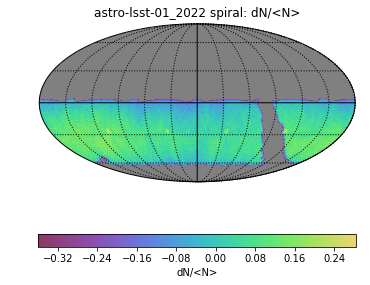

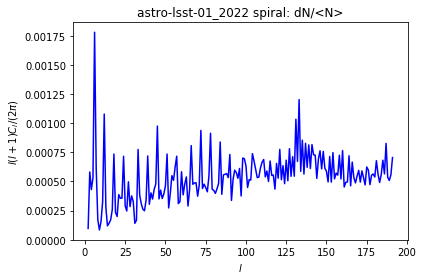

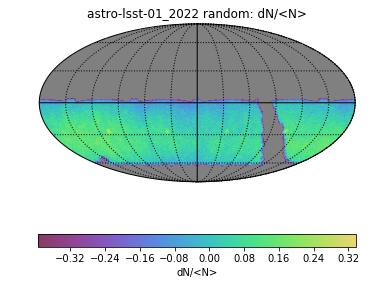

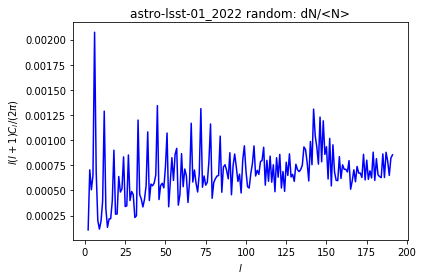

In [12]:
# Cut out the areas which moved pointings into areas of the sky which are not imaged very much (remove 'edges')
for dither in myBundles:
    # Don't cut the non-dithered case
    if dither == 'undithered':
        continue
    else:
        # Cut at 5th percentile -- just empirically determined (adjust as necessary)
        cutlevel = np.percentile(myBundles[dither].metricValues.compressed(), 5.)
        print(cutlevel)
        newmask = np.where(myBundles[dither].metricValues < cutlevel)[0]
        # Add this to the existing mask
        myBundles[dither].metricValues.mask[newmask] = True
        myBundles[dither].plot(plotHandler=plotHandler, plotFunc=plots.HealpixSkyMap)
        myBundles[dither].plot(plotHandler=plotHandler, plotFunc=plots.HealpixPowerSpectrum)

Now we can do a few additional things: 
* calculate the total power (using the summary metric "TotalPowerMetric")
* create a plot with the power spectrum from all examples, together with the total power information in the legend.

In [13]:
summarymetric = metrics.TotalPowerMetric(removeDipole=False)
for dither in myBundles:
    myBundles[dither].setSummaryMetrics(summarymetric)
    myBundles[dither].computeSummaryStats()
    print('## Total power for %s case is %f.' %(dither, myBundles[dither].summaryValues['TotalPower']))
    # Add this to a legend label
    myBundles[dither].setPlotDict({'label':'%s total power %.3f' %(dither, 
                                                                   myBundles[dither].summaryValues['TotalPower'])})

## Total power for undithered case is 0.066207.
## Total power for spiral case is 0.004566.
## Total power for random case is 0.005514.


monopole: -0.0508315  dipole: lon: 169.439, lat: -70.318, amp: 0.131992
monopole: -0.0210374  dipole: lon: 158.853, lat: -72.5241, amp: 0.132021
monopole: -0.0202934  dipole: lon: 155.89, lat: -72.653, amp: 0.13142


/Users/lynnej/lsstsw2/miniconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


1

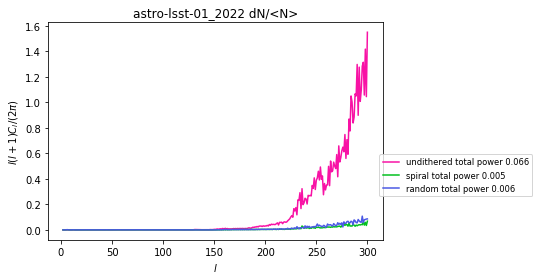

In [14]:
plotHandler.setMetricBundles(myBundles)
plotHandler.plot(plotFunc=plots.HealpixPowerSpectrum(), 
                 plotDicts={'legendloc':(0.99, 0.2), 'title':'%s dN/<N>' %runName, 
                            'removeDipole':True, 'maxl':300})

In [15]:
# Look at what was written to output directory. 
!ls $outDir

astro-lsst-01_2022_GalaxyCounts_No_dithering_HEAL.npz
astro-lsst-01_2022_GalaxyCounts_No_dithering_HEAL_PowerSpectrum.pdf
astro-lsst-01_2022_GalaxyCounts_No_dithering_HEAL_SkyMap.pdf
astro-lsst-01_2022_GalaxyCounts_Random_dither_HEAL.npz
astro-lsst-01_2022_GalaxyCounts_Random_dither_HEAL_PowerSpectrum.pdf
astro-lsst-01_2022_GalaxyCounts_Random_dither_HEAL_SkyMap.pdf
astro-lsst-01_2022_GalaxyCounts_Spiral_dither_HEAL.npz
astro-lsst-01_2022_GalaxyCounts_Spiral_dither_HEAL_PowerSpectrum.pdf
astro-lsst-01_2022_GalaxyCounts_Spiral_dither_HEAL_SkyMap.pdf
astro-lsst-01_2022_GalaxyCounts_dither_Spiral_Random_dither_No_dithering_HEAL_ComboPowerSpectrum.pdf
astro-lsst-01_2022_GalaxyCounts_dithering_No_Spiral_dither_dither_Random_HEAL_ComboPowerSpectrum.pdf
resultsDb_sqlite.db
thumb.astro-lsst-01_2022_GalaxyCounts_No_dithering_HEAL_PowerSpectrum.png
thumb.astro-lsst-01_2022_GalaxyCounts_No_dithering_HEAL_SkyMap.png
thumb.astro-lsst-01_2022_GalaxyCounts_Random_dither_HEAL_PowerSpectrum.png
thumb.a

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
monopole: 127.302  dipole: lon: 141.29, lat: -73.7233, amp: 21.1525
{'Mean': 135.64913567554345}


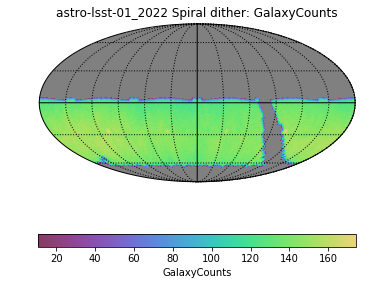

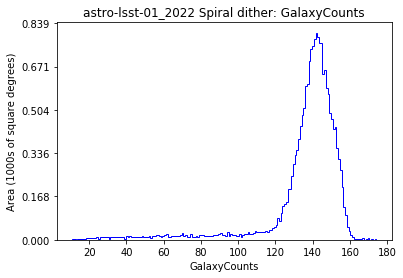

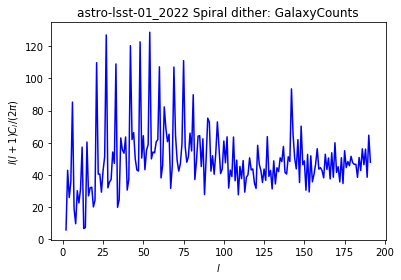

In [16]:
# And note that we could 'reboot' and read the metric information back in, then restart.
newBundle = metricBundles.MetricBundle(metric=metrics.BaseMetric(), slicer=slicers.BaseSlicer(), 
                                      constraint=sqlconstraint)
newBundle.read(os.path.join(outDir, runName+'_GalaxyCounts_Spiral_dither_HEAL.npz'))
# Note - because we wrote the data file (automatically) when doing 'runAll' this is the original galaxy counts data,
# not masked or reduced to dN/N  
newBundle.plot()
summarymetric = metrics.MeanMetric()
newBundle.setSummaryMetrics(summarymetric)
newBundle.computeSummaryStats()
print(newBundle.summaryValues)